# Finding Signals

## Overview

In this lab, you will explore NetFlow data once again, this time applying signals analysis techniques with the goal of threat hunting hidden signals!

## Goals

By the end of this lab, you should be able to:

 * Clearly understand what the Discrete Fourier Transform does
 * Develop an intuitive understanding of how to tune the DFT parameters to identify interesting signals
 
## Estimated Time: 60 minutes

The data that we will be working with is, again, in the NetFlow repository on the `595data.enclaveforensics.com` server.  We need to interact with that system over SSH to run commands.  Let's first get a proof-of-concept working.

# <img src="../images/task.png" width=20 height=20> Task 5.1

Use the Paramiko library to execute the following command on the `595data.enclaveforensics.com` server.  Don't forget that we have done this before, so feel free to look back at the past notebooks.

```
/usr/local/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 \
    --end-date 2019/05/03 --pass=stdout | rwcount --delimited=, --bin-size 3600
```

In [1]:
import paramiko

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy)
ssh.connect(hostname='595data.enclaveforensics.com', username='sans', password='training')

_, stdout, _ = ssh.exec_command('/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 --end-date 2019/05/03 --pass=stdout | rwcount -delimited=, --bin-size 3600')
result = stdout.read()

print(result.decode('ascii'))


Date,Records,Bytes,Packets
2019/05/02T16:00:00,243.65,724914.45,3305.47
2019/05/02T17:00:00,4315.18,14181510.73,103822.62
2019/05/02T18:00:00,1944.00,5775336.20,37020.75
2019/05/02T19:00:00,1572.64,6738147.39,66393.29
2019/05/02T20:00:00,1884.69,15395203.11,156596.46
2019/05/02T21:00:00,5377939.46,10005227134.92,166663757.70
2019/05/02T22:00:00,9265199.65,17236810352.00,287201240.43
2019/05/02T23:00:00,9099238.08,16925299636.66,282053445.72
2019/05/03T00:00:00,9185910.22,17086228466.79,284730324.45
2019/05/03T01:00:00,9167988.19,17044701649.77,284043491.48
2019/05/03T02:00:00,1557139.17,2898397549.16,48242918.18
2019/05/03T03:00:00,966.26,2839682.82,20712.70
2019/05/03T04:00:00,1575.55,3045632.34,16561.76
2019/05/03T05:00:00,1386.62,3201176.39,16166.00
2019/05/03T06:00:00,1750.75,10115611.24,85306.66
2019/05/03T07:00:00,1677.55,9930076.87,84542.31
2019/05/03T08:00:00,1818.28,4134137.43,22700.64
2019/05/03T09:00:00,1979.21,3974993.58,20736.60
2019/05/03T10:00:00,2648.78,9477636.67,73781

What this output shows is the number of flows beginning with a SYN packet each hour over the course of 23 hours.  Before we work with this more, though, there's something else that we have to address.

We have interacted with a remote system using SSH several times now.  While the code to do so isn't difficult, interacting with SSH is not a task we will do every day.  This means that, at least for me, I will find myself referring to the documentation every single time.  This is a very big indicator that we should probably abstract this into some utility function or class that we can import and reuse.

# <img src="../images/task.png" width=20 height=20> Task 5.2

Create a class named *SSHCommand.*  The initializer for the class should allow you to pass arguments to define the remote host, the username, and the password.  The class should have an instance method `execute()` that takes one keyword argument, *command.*  This helper function should return the result of the executed command decoded as ASCII.

In [2]:
import paramiko

class SSHCommand:
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
        self.ssh = paramiko.SSHClient()
        self.ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy)
        self.ssh.connect(hostname=address, username=username, password=password)

    def execute(self, command = ""):
        _, stdout, _ = self.ssh.exec_command(command)
        result = stdout.read()
        return result.decode('ascii')


# <img src="../images/task.png" width=20 height=20> Task 5.3

Use your newly built class to retrieve the results to the following command:

```
/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 \
    --end-date 2019/05/03 --pass=stdout | /bin/rwcount -delimited=, --bin-size 3600
```

Capture this output in a variable

In [3]:
ssh = SSHCommand(address='595data.enclaveforensics.com', username='sans', password='training')
result = ssh.execute('/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 \
    --end-date 2019/05/03 --pass=stdout | /bin/rwcount -delimited=, --bin-size 3600')

We now have that result in a string, but we'd prefer to manipulate it as data.  We have several different paths that we could take at this point.  We could:

* Parse the text into values directly, building up a dataset
* Leverage an existing tool that will allow us to go from text to numpy array easily

The second option sounds pretty good.  This isn't something new for us.  Let's pull the steps together into our next task.

# <img src="../images/task.png" width=20 height=20> Task 5.4

Create a convenience function that takes text data that is structured as CSV and returns a dataframe.  To accomplish this task, you should:

* Use the *StringIO* object from the *io* package
* Use Pandas to read that string object as a CSV file

Once you have this defined, use it to convert your data to a dataframe and then display it.

In [4]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

df = string_to_df(result)
df

,Date,Records,Bytes,Packets
0,2019/05/02T16:00:00,243.65,7.249144e+05,3.305470e+03
1,2019/05/02T17:00:00,4315.18,1.418151e+07,1.038226e+05
2,2019/05/02T18:00:00,1944.00,5.775336e+06,3.702075e+04
3,2019/05/02T19:00:00,1572.64,6.738147e+06,6.639329e+04
4,2019/05/02T20:00:00,1884.69,1.539520e+07,1.565965e+05
5,2019/05/02T21:00:00,5377939.46,1.000523e+10,1.666638e+08
6,2019/05/02T22:00:00,9265199.65,1.723681e+10,2.872012e+08
7,2019/05/02T23:00:00,9099238.08,1.692530e+10,2.820534e+08
8,2019/05/03T00:00:00,9185910.22,1.708623e+10,2.847303e+08
9,2019/05/03T01:00:00,9167988.19,1.704470e+10,2.840435e+08


Pandas incorporates the ability to generate basic Matplotlib charts.  For example, we can use the `plot()` method on a dataframe to generate a plot.  To do so, we need to define a few arguments.

Please feel free to review the help for the `plot()` function.  For now, we will require:

* `x` - Defines the column to use as the x-axis
* `y` - Defines the column to use as the y-axis

If you simply plot the data this way, the date column will be used as the label on the x axis.  This is fine, except that the labels will all be smushed together and impossible to read.  To prevent this, you might also pass `rot=90` to rotate the labels 90 degrees.

# <img src="../images/task.png" width=20 height=20> Task 5.5

Plot the dataframe using the `Date` column as the x-axis and `Packets` as the y-axis.

<Axes: xlabel='Date'>

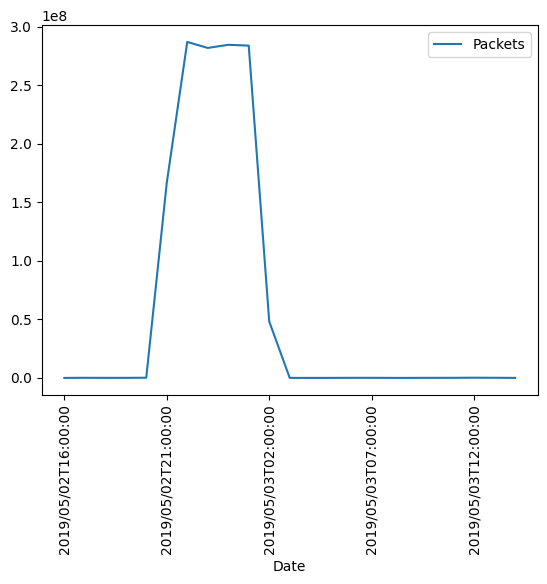

In [5]:
df.plot(x="Date", y="Packets", rot=90)

If this graph is to be believed, there are only packets in six out of the 23 hours present.  This seems suspicious.

We've seen this type of problem before.  Notice the scale of the y-axis.  $1\times10^8$.  Is it possible that there are packets in the other hours but that the scale of the axis is so large that they vanish?  Do you recall how we solved this problem previously?

Matplotlib allows us to change to a logarithmic scale.  We can do that with dataframes as well by passing *True* to the `logy` or `logx` keyword arguments.

# <img src="../images/task.png" width=20 height=20> Task 5.6

Plot the data again, this time using a logarithmic scale.

<Axes: xlabel='Date'>

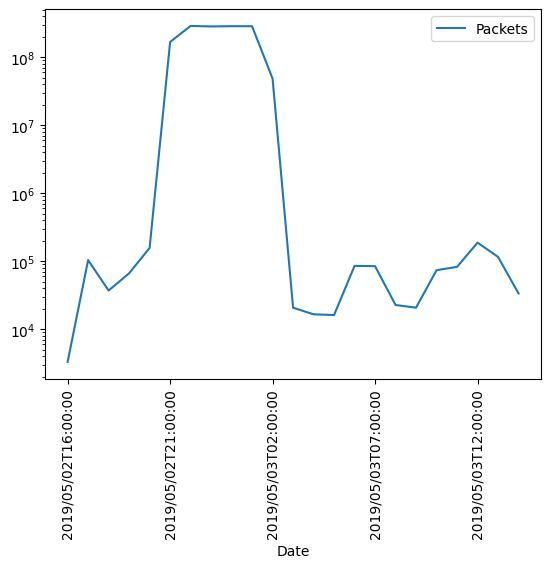

In [6]:
df.plot(x="Date", y="Packets", rot=90, logy=True)

We can now see that there is activity throughout the time period.  But are there patterns in this data?  To answer this question, let's try to look at our data in different ways.  First, it seems reasonable that we may need to look at the data more granularly than as hourly chunks.

# <img src="../images/task.png" width=20 height=20> Task 5.7

Please use your SSH class to retrieve the results from the following query:

```
/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 
    --end-date 2019/05/03 --pass=stdout | /bin/rwcount -delimited=, --bin-size 600
```

This query is nearly identical, except that we are now looking at data in 10 minute bins rather than 1 hour bins.  Plot the data using a logarithmic scale.  We need to make one other change.

If we use the defaults, Pandas will attempt to print every date as a label along the x-axis.  Let's disable this.  We really don't care what the date or time is, we care about how the data behaves.  To turn this off, pass the keyword argument `use_index` setting it to `False`.  We also want to pass the parameter `xticks=[]` which sets the `xticks` parameter to an empty list.  This will speed things up a lot. 


<Axes: >

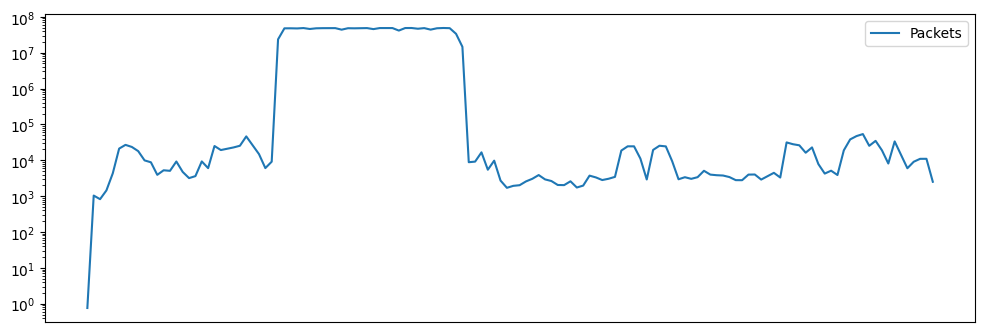

In [7]:
result = ssh.execute('/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 --end-date 2019/05/03 \
    --pass=stdout | /bin/rwcount -delimited=, --bin-size 600')
df = string_to_df(result)
df.plot(x="Date", y="Packets", logy=True, use_index=False, xticks=[], figsize=(12,4))

This is starting to look interesting and we can see some detail in the points, but is there more detail to see?  Let's zoom in further, using a bin size of 60 seconds rather than 10 minutes.

# <img src="../images/task.png" width=20 height=20> Task 5.8

Adjust the `bin_size` argument in the command that we have been passing to the NetFlow repository over SSH to be 60 seconds.  Then rerun the same query (with this adjustment) and plot the data in the same way as the last task.


<Axes: >

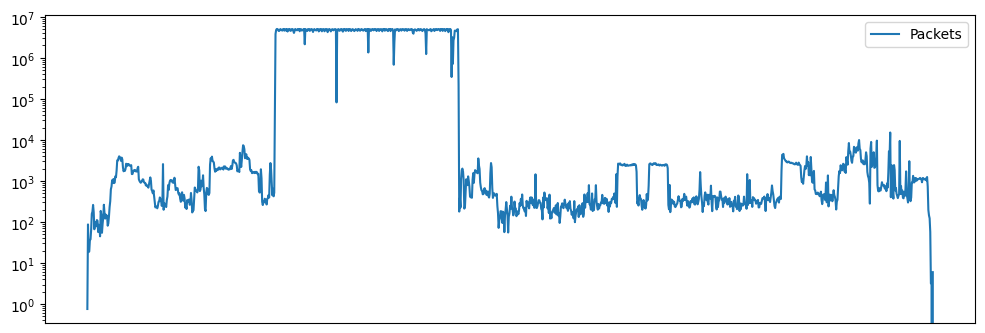

In [8]:
result = ssh.execute('/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 --end-date 2019/05/03 \
    --pass=stdout | /bin/rwcount -delimited=, --bin-size 60')
df = string_to_df(result)
df.plot(x="Date", y="Packets", logy=True, use_index=False, xticks=[], figsize=(12,4))

We can now see more and more detail emerging.  Let's go even closer, using a bin size of 10 seconds.

# <img src="../images/task.png" width=20 height=20> Task 5.9

Adjust the bin size again, this time to 10 seconds.  Produce the plot again.

<Axes: >

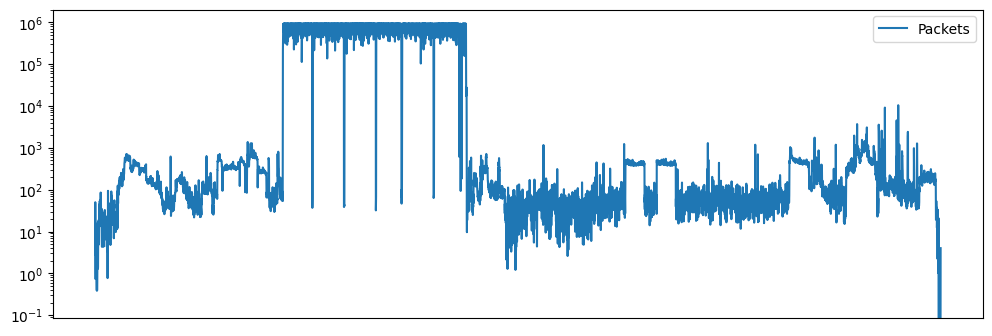

In [9]:
result = ssh.execute('/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 --end-date 2019/05/03 \
    --pass=stdout | /bin/rwcount -delimited=, --bin-size 10')
df = string_to_df(result)
MAX_Y =  (df.loc[:, 'Packets']).max()
df.plot(x="Date", y="Packets", logy=True, use_index=False, xticks=[], figsize=(12,4))

Let's have a look at the numbers of packets and see if we can find any interesting periodic patterns in it.  To do this, we will assume that it is periodic and pass it to the Discrete Fourier Transformation function and have it tell us whether it is or not.

Doing this is much easier than it sounds.  Let's convert the *Packets* column to a numpy array first.  We can do this with the `loc` feature of the dataframe.

# <img src="../images/task.png" width=20 height=20> Task 5.10

Extract the *Packets* column from the dataframe as a Numpy array.

In [10]:
import numpy as np
packets = df.loc[:, 'Packets']

We're now ready to process the DFT.  The DFT in Numpy comes in many forms.  From our perspective, there are two main categories:

* The "Normal" functions, which expect the input array to be conjugate pairs of complex numbers
* The "Real" functions, which allow us to pass real valued input without worrying about complex numbers

We will be using the second type.  There is a consequence of this, which we will see shortly.  The specific version of the function that we want to use is the `np.fft.rfft()` function.

```
fft.rfft(a, n=None, axis=-1, norm=None)
Compute the one-dimensional discrete Fourier Transform for real input.

This function computes the one-dimensional n-point discrete Fourier Transform (DFT) of
 a real-valued array by means of an efficient algorithm called the Fast Fourier 
 Transform (FFT).

Parameters
aarray_like
Input array

nint, optional
Number of points along transformation axis in the input to use. If n is smaller than 
the length of the input, the input is cropped. If it is larger, the input is padded 
with zeros. If n is not given, the length of the input along the axis specified by axis 
is used.

axisint, optional
Axis over which to compute the FFT. If not given, the last axis is used.

norm{“backward”, “ortho”, “forward”}, optional
New in version 1.10.0.

Normalization mode (see numpy.fft). Default is “backward”. Indicates which direction 
of the forward/backward pair of transforms is scaled and with what normalization factor.

New in version 1.20.0: The “backward”, “forward” values were added.

Returns
outcomplex ndarray
The truncated or zero-padded input, transformed along the axis indicated by axis, or 
the last one if axis is not specified. If n is even, the length of the transformed axis 
is (n/2)+1. If n is odd, the length is (n+1)/2.

Raises
IndexError
If axis is larger than the last axis of a.
```

# <img src="../images/task.png" width=20 height=20> Task 5.11

Use the Numpy `rfft()` function to process the packet data.  Capture the result in a variable and display it.

In [11]:
fft = np.fft.rfft(packets)
fft

array([ 1.35406178e+09+0.00000000e+00j, -5.97204718e+08-1.10020208e+09j,
       -5.32412877e+08+8.19171938e+08j, ...,
       -9.74252006e+05-3.20533962e+05j,  5.46076980e+05+7.65415092e+05j,
       -1.69006266e+05-8.06769938e+05j])

The resulting data represents magnitudes at different frequencies.  What are the frequencies?  This all depends on the data that we pass in.  To work out the frequencies, we need to know what the frequency width is of the bins generated by the `rfft()` function along with the number of bins that are present.  We also need to know how many samples were present in our data and what the sampling frequency was.
 
We know the number of samples. We can easily determine the number of bins generated.  We also know the spacing of the samples, which we can interpret as frequency, but what does this value represent?

## This Is a Really Big Deal

Nearly everything that you will find in literature about the FFT and Fourier transformations in general is from the field of signals analysis and electronics.  Since these fields deal with fast signals (many cycles per second), all of the documentation is focused on using these functions to solve the type of problem we have right now.  This can create a difficult mental task for us if we try to apply these functions to signals that are *slower* than 1 hertz.

If you think about this a bit you may realize that there need be no such problem.  While we customarily use sampling rates that are expressed in hertz, there is nothing about the Discrete Fourier Transformation function that actually *requires* that we express things in terms of hertz.  This means that we can *arbitrarily define the function to use any units we'd like!*  Said another way, rather than focusing on cycles per second, we could express things in terms of minutes, hours, days, weeks, months, or more.

In this specific case, perhaps it makes sense to express things in terms of days, or 24 hour periods.  If we think of it this way, sampling bins that are ten seconds wide would amount to a sampling rate of 8,640 samples per day.

If there are any signals found in this data, we will use this insight to determine how frequently they are occurring.

# <img src="../images/task.png" width=20 height=20> Task 5.12

Please use Matplotlib to plot the FFT data.  When you do so, you should expect to receive the following warning:

>ComplexWarning: Casting complex values to real discards the imaginary part


This is completely expected.  The values returned by the DFT will have complex components.  Since we aren't interested in them, we will just ignore them.  Plotting the data on $\mathbb{R}^2$ axes will discard the complex components automatically.

/home/matt/my_python_env/AI/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/matt/my_python_env/AI/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


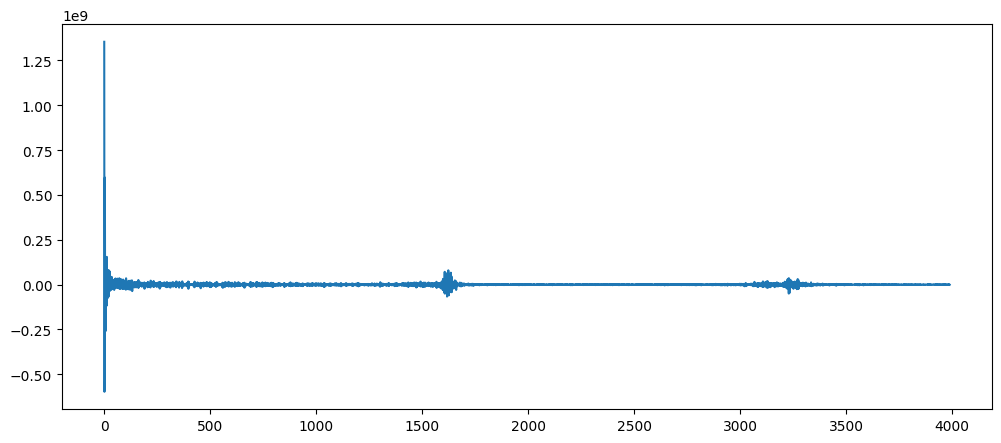

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()

To determine the frequencies that are present, we need to determine the "Shannon Limit" or "Nyquist Frequency", which is $\frac{1}{2}$ the sampling frequency and then perform some calculations.  The frequencies represented on by each value in the NumPy array returned by the `rfft()` function range from zero through the Nyquist frequency.  The width of each frequency is the Nyquist frequency divided by the number of bins, or the length of the array.

# <img src="../images/task.png" width=20 height=20> Task 5.13

* Calculate the Nyquist frequency for our data, assuming that the basic unit of measure is 1 cycle per 24 hour period.
* Using the Nyquist frequency and the data returned by `rfft()`, determine the width of each frequency bin.
* Plot the FFT data using the frequency information that you have calculated to label the x axis.

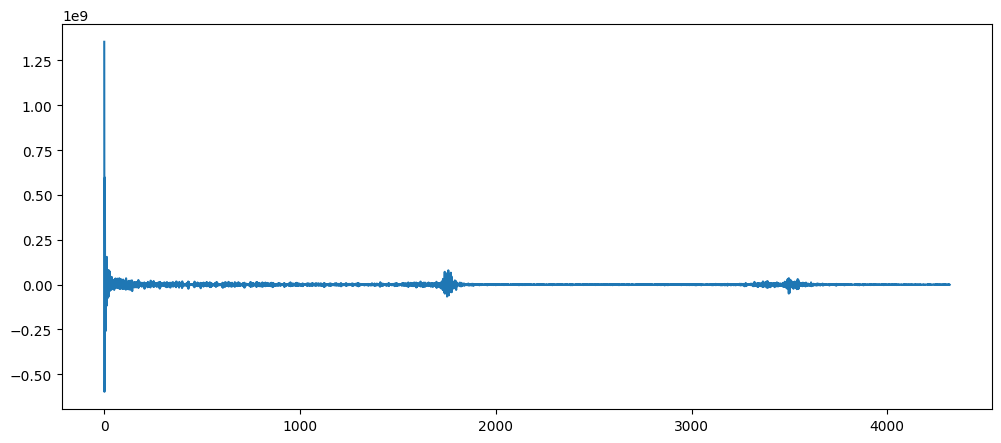

1.0829781900225621


In [13]:
nyquist = 8640/2  # 10 seconds per bin, or 8,640 samples per day
num_bins = len(fft)
bin_width = nyquist / num_bins

frequencies = [i * bin_width for i in range(num_bins)]
plt.figure(figsize=(12,5))
plt.plot(frequencies,fft)
plt.show()
print(bin_width)

Wow, that was easy!  But what can we do with it?  We can see that there is activity around zero, something around 1800 and something around 3500.  How can we zoom this data in?  What does some of it mean?

As far as zooming in, one approach would be to plot only a subset of the data.  Another approach would be to zoom in by changing the scale of the y-axis.  Let's try this first.

# <img src="../images/task.png" width=20 height=20> Task 5.14

Use the `plt.ylim()` function to change the scale of the y axis so that you can see more detail around what appear to be coherent signals.  A suggested value for the maximum $y$ value to plot is $1e8$, or $100,000,000$.

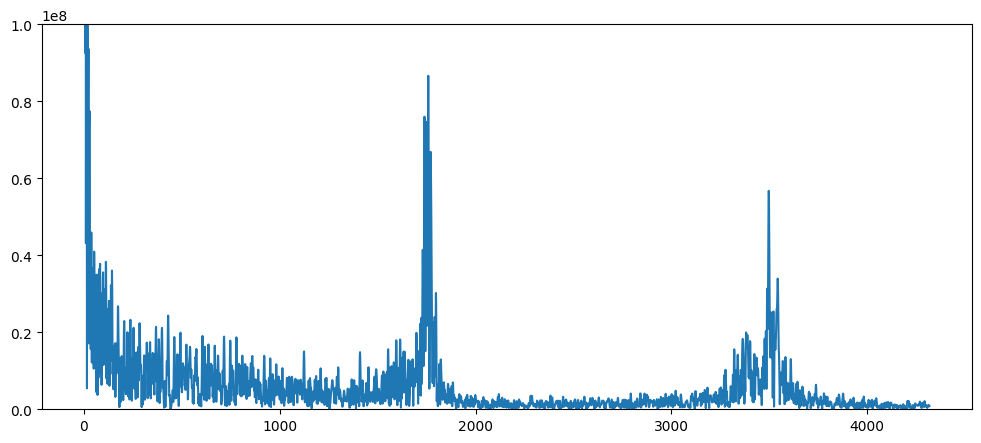

In [14]:
plt.figure(figsize=(12,5))
plt.ylim(0,1e8)
plt.plot(frequencies,abs(fft))
plt.show()

We can see the spikes much more clearly now, but what about the massive spike at and around zero?  There are two things happening here.

The first is an artifact of using a tool (Fourier transformations) that are intended to operate on complex data.  Since we do not have complex data to start with, we end up with what is called a "DC Offset."  This term, while not directly applicable to our task, comes from using a Fourier transformation on direct current signals.  The signal will inherit an "offset" that indicates the DC constant current and this will appear at $0$ in the resulting FFT.  In our case, we can simply disregard this.

# <img src="../images/task.png" width=20 height=20> Task 5.15

Plot the data again, just as you did in the last task, but ignore the data at offset zero.

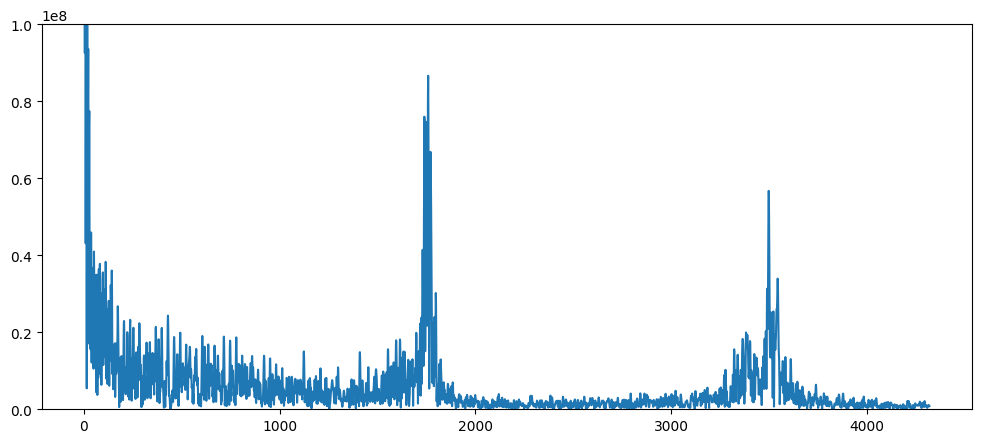

In [15]:
plt.figure(figsize=(12,5))
plt.ylim(0,1e8)
plt.plot(frequencies[1:],abs(fft[1:]))
plt.show()

While this shows some very modest improvement, there is still *a lot* of data around zero.  What is this?

Take a moment and think about what it is that we are measuring.  We are looking at discrete network packets appearing on the network.  If you reflect on how networks function, you might realize that the network itself generates packets at discrete intervals, though those intervals are very small.  In other words, what we are looking at around zero is the collection of things that happen on a network normally at speeds faster than or approaching the maximum resolution of our FFT.

If we wanted to, we could certainly sample our data even more frequently, making our NetFlow bins smaller, but there is little or no value in doing so.  We will definitely find signals, but they will rarely, if ever, be useful in terms of finding threats.  We are interested in the periodic signals that occur at something more than a minute, or multiple minutes, or hours.  These are typical of malware beaconing.

The rest of the data between this pile-up around zero and the first spike would be the "noise floor" of the data.  That is, there are things happening on the network, but the density of signals with that specific periodicity is not particularly high.  These are all floating below $0.2 \times 10^8$, which is our scale on the left.

# <img src="../images/task.png" width=20 height=20> Task 5.16

With the above discussion please plot the data again, this time ignoring the first 500 values in the FFT.

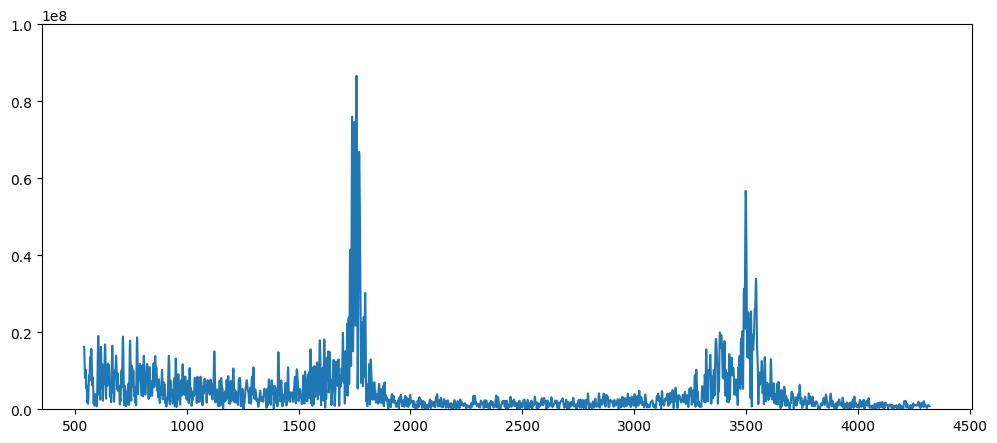

In [16]:
plt.figure(figsize=(12,5))
plt.ylim(0,1e8)
plt.plot(frequencies[500:],abs(fft[500:]))
plt.show()

We can now see some very clear spikes in the data.  Look carefully at the shapes of these spikes and what is happening around them.  The one to the right appears to be of lower power, but cleaner.  The first one is more strongly represented, and has other data mixed in around it, but it does appear to be fairly *symmetric* compared to the signal to the right.

To be fair, these could be entirely different signals in the data.  However, our experience and the close symmetry makes us believe that the spike on the right is just a *harmonic* of the primary signal on the left.  What is a harmonic?  We won't go into any depth explaining the term, but if you reflect back on the course book, you may recall the discussion that mentioned that we can generate a square wave using a series expansion of sine values.  more specifically, it is the series expansion of *odd harmonics*.  These odd terms get progressively smaller as the expansion continues toward infinity, and each of them represents a harmonic that is resonant with the primary signal.  Our opinion is that the data to the right is just a harmonic of the primary signal.

Let's define a threshold value to see if we can automatically find signals in an FFT.

# <img src="../images/task.png" width=20 height=20> Task 5.17

Generate some statistics using the FFT data, ignoring the first 500 elements.  Find the:

* Mean value
* Median value
* Standard deviation

In [17]:
mean = np.mean(abs(fft[500:]))
median = np.median(abs(fft[500:]))
stddev = np.std(abs(fft[500:]))

print(f'Mean: {mean}, Median: {median}, Std: {stddev}')

Mean: 4745835.802558272, Median: 2501232.8781076977, Std: 7140954.806228984


Let's look at our data using some of these statistics as filters.

# <img src="../images/task.png" width=20 height=20> Task 5.18

Using the `np.argwhere()` function, determine a combination of median, mean, and standard deviation values that isolates the 30 largest values found in the FFT data at an offset in the array greater than 500.

*Hint:* Don't forget to use the `abs(fft[500:])` for your evaluation.

In [18]:
np.argwhere(abs(fft[500:]) > mean + stddev*5)

array([[1098],
       [1104],
       [1105],
       [1106],
       [1107],
       [1108],
       [1113],
       [1114],
       [1115],
       [1116],
       [1117],
       [1118],
       [1119],
       [1122],
       [1123],
       [1124],
       [1125],
       [1126],
       [1133],
       [1134],
       [1135],
       [1136],
       [1137],
       [1138],
       [1139],
       [2728],
       [2729],
       [2730],
       [2731],
       [2732]])

The indices of the values that we have found are relative to the limited amount of data passed into `np.argwhere()`.  If we wanted to find the original values, we need to add 500.  For our purposes, however, the reduced dataset will work fine.

What we have right now is a tool that we could use to automatically identify a signal that rises far above the noise floor in the FFT.  Now, rather than having an analyst run and look at hundreds of FFTs, we can skip the plotting step and simply use something like $\mu_{FFT} + (\sigma^2_{FFT}\times 5)$ as a threshold value.

# <img src="../images/task.png" width=20 height=20> Task 5.19

What is the largest value that appears in the FFT data at a position greater than 500?

In [19]:
np.max(abs(fft[500:]))

86612952.52357703

What can we do with this?  Consider this logic:

* Create an automated job that generates an FFT based on network connections periodically.
* Using either a predefined threshold or a threshold intrinsic to the FFT generated, see if there is evidence of one or more signals.
* If a signal is found, obtain a list of all of the IP addresses initiating connections in that time frame.
* Iterate over this list, generating an FFT for each address, checking to see if that address has evidence of a signal exceeding the threshold determined previously.

In other words, we can automate *all of this* to create a threat hunting tool that runs in our environment regularly, reporting to analysts.  How difficult would this code be to write?  We have included it in the cell below the conclusion.

**PLEASE DO NOT RUN THIS CODE AGAINST THE LIVE SERVER**

Imagine the impact on our cloud server if fifty students all started running this job simultaneously!

# Conclusion

It's much easier to see that there are interesting things happening right around zero and then again at just above two.  We can find these spikes by examining the data returned from the `rfft()` function, looking for values that rise above the *noise floor*, or the non-coherent "stuff" that has no clear spikes.  This can allow us to translate the position of the spike to a frequency.  What do we do with that?  We go back to our data, but we now know that we are looking for something that occurs with a specific period.

The data, as we have viewed it, is the aggregate of all of the SYNs on the network.  That means that we are seeing what appears to be a coherent signal that could be a single host, a group of hosts, or different hosts all acting with some regular frequency.

Could we take this approach and apply it to individual systems?  Could we apply it to specific ports?  Or perhaps apply it iteratively to *all* ports or hosts?  Of course!  When we do so, finding things mathematically rather than visually becomes more important.  Can you think of a way to do that?  We hope you are thinking of statistics!

What if we took the FFT data and worked out the average power density or signal strength across all of the data?  Could we couple that with the standard deviation to begin to find thresholds for activities that would be interesting?  With that completed, we can then apply an ongoing iterative and automatic analysis of hosts, ports, etc., generating alerts to the analyst when patterns are found.

In this case we can see that there is a spike at around 1800 samples.  What would that mean?  Since our scale is 8640 cycles (or time periods) per day, this implies that we would be looking for network connections (TCP SYN packets) that are occurring regularly at something like a four to five our period.

In [ ]:
# Sample code to automate finding a host that shows evidence of a strong signal:


def process_host(host, threshold = 80000000):
    result = ssh.execute(f'/bin/rwfilter --type=all --saddress={host} --flags-initial S/SA --start-date 2019/05/01 --end-date 2019/05/03 \
    --pass=stdout | /bin/rwcount -delimited=, --bin-size 10')
    host_df = string_to_df(result)
    packets = host_df['Packets']
    fft = np.fft.rfft(packets)
    return np.any(abs(fft[500:]) > threshold)
    
# Get a list of all IP addresses seen initiating connections
result = ssh.execute('/bin/rwfilter --type=all --flags-initial S/SA --start-date 2019/05/01 --end-date 2019/05/03 \
    --pass=stdout | /bin/rwuniq --fields sip --delimited=","')
hosts_df = string_to_df(result)
hosts = np.array(hosts_df['sIP'])

for host in hosts:
    alert = process_host(host, threshold=(mean + stddev*4)) # From our calculation above, with slightly smaller threshold
    # print(host)
    if alert:
        print(f"Possible signal found!  Host {host}.")